In [ ]:
%pip install split-folders tensorflow matplotlib scipy

In [1]:
%pip install numpy==1.24.3 scikit-learn==1.3.2

  Using cached numpy-1.24.3.tar.gz (10.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "c:\Users\dudum\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "c:\Users\dudum\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\dudum\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
          backend = _build_backend()
                    ^^^^^^^^^^^^^^^^
        File "c:\Users\dudum\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
          obj = import_m

In [ ]:
import os
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
original_data_dir = 'dataset'
base_dir = 'split_dataset'

Divisão dos dados usando splitfolders

In [4]:
#if not os.path.exists(base_dir):
splitfolders.ratio (
    original_data_dir,
    output=base_dir,
    seed=42,
    ratio=(0.7, 0.15, 0.15),
    group_prefix=None,  # Opcional, mantém agrupamento de prefixos semelhantes
    move=False  # Copia os arquivos ao invés de movê-los
)

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

Copying files: 443 files [00:01, 361.92 files/s]


Geradores de dados com aumentação para treino

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

Gerando os dados a partir das imagens

In [6]:
batch_size = 32
image_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Não embaralhar para facilitar a avaliação
)

Found 303 images belonging to 4 classes.
Found 64 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [7]:
print(train_generator.class_indices)

{'Bacterial_dermatosis': 0, 'Fungal_infections': 1, 'Healthy': 2, 'Hypersensitivity_allergic_dermatosis': 3}


Modelo base InceptionV3 (pré-treinado no ImageNet)

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar as camadas pré-treinadas

Construção do modelo

In [9]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Aumentado o dropout para regularização
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

In [10]:
import PIL
print(PIL.__version__)

11.1.0


In [11]:
# Compilação do modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_cb = ModelCheckpoint(
    'best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'
)
early_stopping_cb = EarlyStopping(
    patience=10, restore_best_weights=True, monitor='val_loss'
)

# Treinamento
epochs = 50
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Avaliação no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Acurácia no teste: {test_accuracy:.2f}")

C:\Users\dudum\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.2206 - loss: 6.1744 - val_accuracy: 0.2344 - val_loss: 1.5502
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4635 - loss: 1.4342 - val_accuracy: 0.2500 - val_loss: 1.4250
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4831 - loss: 1.2043 - val_accuracy: 0.4688 - val_loss: 1.2795
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5714 - loss: 1.0290 - val_accuracy: 0.4062 - val_loss: 1.2777
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6275 - loss: 1.0037 - val_accuracy: 0.4688 - val_loss: 1.3046
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6695 - loss: 0.8175 - val_accuracy: 0.4844 - val_loss: 1.3426
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5782 - loss: 0.9780 - val_accuracy: 0.3438 - val_loss: 1.2856
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6447 - loss: 0.8361 - val_accuracy: 0.4219 - val_loss:

Plotando os gráficos

In [15]:
import seaborn as sns
from sklearn.metrics import classification_report

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step
Acurácia: 0.76
Precisão: 0.77
Recall: 0.76
F1-Score: 0.76


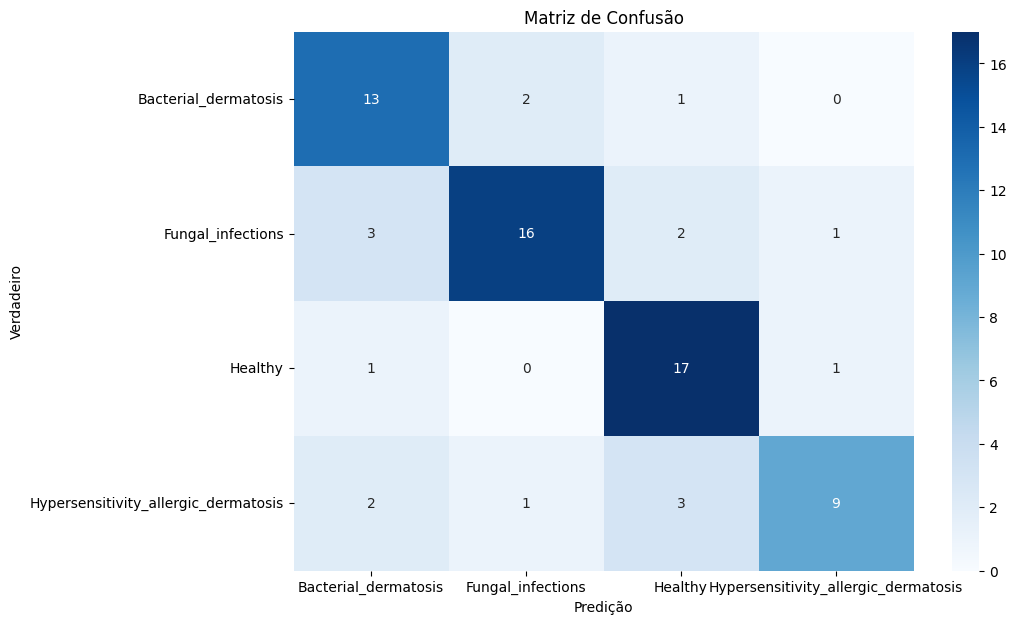

Relatório de Classificação:
                                      precision    recall  f1-score   support

                Bacterial_dermatosis       0.68      0.81      0.74        16
                   Fungal_infections       0.84      0.73      0.78        22
                             Healthy       0.74      0.89      0.81        19
Hypersensitivity_allergic_dermatosis       0.82      0.60      0.69        15

                            accuracy                           0.76        72
                           macro avg       0.77      0.76      0.76        72
                        weighted avg       0.77      0.76      0.76        72



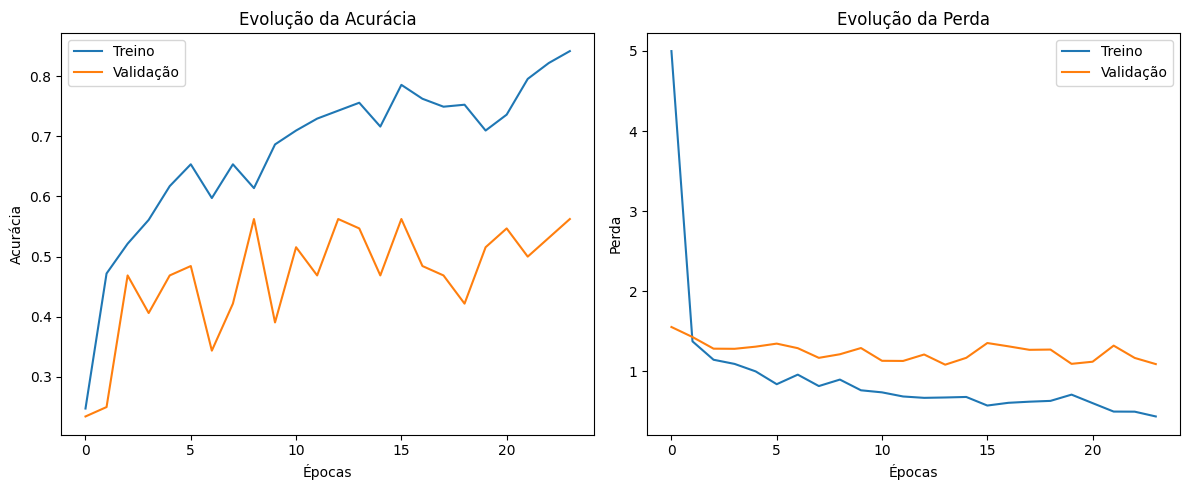

In [16]:
# Prevendo as classes para o conjunto de teste
y_true = test_generator.classes  # Classes reais
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # As classes previstas

# Calculando as métricas detalhadas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.show()

# Relatório de classificação
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Relatório de Classificação:")
print(report)

# Visualizando a evolução da acurácia e da perda
plt.figure(figsize=(12, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Evolução da Acurácia')

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Evolução da Perda')

plt.tight_layout()
plt.show()